In [ ]:
# Run this within the NESattack directory 
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [10]:
import cv2
import random
# import GPyOpt as gy
# import noise as ns
import tensorflow as tf
import torch
import torchvision
from torchvision import transforms
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
import math

import time as time


mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [11]:
main_path = os.path.dirname(os.path.abspath(".")) #path of main folder
data_path = os.path.join(main_path, "data", "imagenet_val") #path of validation data

images = {}
classfiles = os.listdir(data_path)
# print(classfiles)

for clf in classfiles:
    images[clf] = os.listdir(os.path.join(data_path,clf))
    
images

{'n01751748': ['ILSVRC2012_val_00000001.JPEG'],
 'n02105855': ['ILSVRC2012_val_00000003.JPEG'],
 'n03125729': ['ILSVRC2012_val_00000005.JPEG'],
 'n04263257': ['ILSVRC2012_val_00000004.JPEG'],
 'n09193705': ['ILSVRC2012_val_00000002.JPEG']}

In [12]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
pretrained_model = pretrained_model.to("cuda")
pretrained_model.eval()

torch_transform = transforms.Compose([
    transforms.
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ImageNet labels
decode_predictions = tf.keras.applications.inception_v3.decode_predictions

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    if len(probs) > 1:
        return decode_predictions(probs, top=6)
    return decode_predictions(probs, top=6)[0]

imagesize = 299

Using cache found in /hpc/home/mb625/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/mb625/anaconda3/envs/DL_final/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/mb625/anaconda3/envs/DL_final/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def torch_transform(image):
    """
    input: numpy images of shape (B, H, W, C), normalized to (0, 1)
    output: tensor of images of shape (B, C, H, W), normalized to mean [.485, .456, .406], std [.229, .224, .225]
    """

    # print(type(image))
    # print(image.shape)
    if not isinstance(image, np.ndarray):
        image = image.numpy()
    image = torch.tensor(image, dtype=torch.float32)
    if len(image.shape) <= 4:
        image = torch.unsqueeze(image, 1)
    # B, 1, H, W, C
    assert image.shape[-1] == 3
    image = torch.transpose(image, 1, 4)
    # B, C, H, W, 1
    assert image.shape[1] == 3 and image.shape[3] == 299
    image = torch.squeeze(image, dim=4)
    # B, C, H, W
    assert image.shape[1] == 3 and image.shape[3] == 299 and len(image.shape) == 4
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = transform(image)
    # print(image.shape)
    return image

def predict(image):
    """
    input: normalized tensor of shape (B, C, H, W)
    output: numpy array of predictions
    """
    # print("predicting")
    with torch.no_grad():
        preds = pretrained_model(torch_transform(image).to("cuda"))
    return preds.cpu().detach().numpy()

def predict_debug(image):
    """
    input: normalized tensor of shape (B, C, H, W)
    output: numpy array of predictions
    """
    # print("predicting")
    with torch.no_grad():
        input = torch_transform(image)
        preds = pretrained_model(torch_transform(image).to("cuda"))
    return preds.cpu().detach().numpy(), input

In [14]:
cls = random.choice(classfiles)
# print(images[cls])
imgfile = random.choice(images[cls])


# imgpath = os.path.join(data_path, cls+"/"+imgfile)
imgpath = os.path.join(data_path, "n02105855/ILSVRC2012_val_00000003.JPEG")


print(imgfile)
print(imgpath)

rawimage = np.array(Image.open(imgpath)) / 255
rawimage = cv2.resize(rawimage, dsize=(imagesize, imagesize))
print(rawimage.shape)

ILSVRC2012_val_00000002.JPEG
/scratch/mb625/Adversarial-Black-Box-Attacker/data/imagenet_val/n02105855/ILSVRC2012_val_00000003.JPEG
(299, 299, 3)


torch.Size([299, 299, 3])
torch.Size([1, 299, 299, 3])


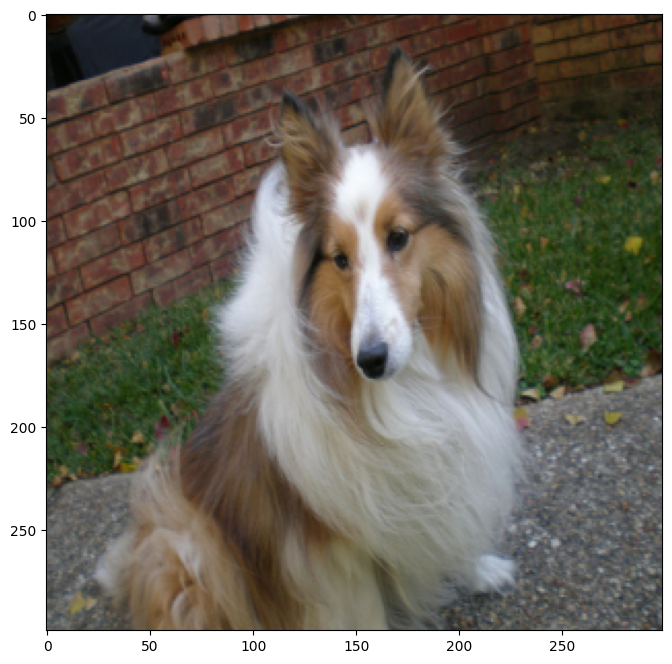

In [15]:
# convert to torch tensor and 
image = torch.tensor(rawimage, dtype=torch.float32) 
print(image.shape)

plt.imshow(image)

# Add batch dimension
# 1, 299, 299, 3
image = torch.unsqueeze(image, 0) 
print(image.shape)


In [16]:
img = image
# print(type(image))
image_probs = get_imagenet_label(predict(image))
labelindex = np.argmax(predict(image))
origpredictions = image_probs[0]

In [17]:
def transforming(image):
    if np.shape(image) == (1,imagesize,imagesize,1):
        image = tf.image.grayscale_to_rgb(image)
    elif np.shape(image) == (1,imagesize,imagesize,4):
        image = tf.image.grayscale_to_rgb(image)

    return torch_transform(image)

In [18]:
with open('./imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

classes = {cls: i for i, cls in enumerate(classes)}
classes['collie']

231

In [19]:
def NES(
    x_orig,
    y_adv,
    y_correct,
    sigma,
    n_samples,
    k
):
    """
    x: np.ndarray
    y_class: str
    sigma: float
    n_samples: int
    img_dim: tuple
    classifier: function
    model: tf.keras.Model
    k: int
    """
    _, r, d, _ = x_orig.shape
    noise = torch.normal(mean = 0, std = 1, size = (n_samples//2, 3, r, d))
    noise = torch.cat([noise, -noise], axis = 0).cuda()
    x_orig = transforming(x_orig)
    x = x_orig.repeat((n_samples, 1, 1, 1)).cuda()
    # print(x.shape, noise.shape)
    x += noise * sigma
    predictions = pretrained_model(x)
    prob = torch.nn.functional.softmax(predictions).detach()[:, y_adv]
    # prob_correct = prob_dist[:, y_correct]
    # print(prob.mean())
    prob = prob[:, None, None, None]
    # prob_correct = prob_correct[:, None, None, None]
    g = prob * noise
    return g.sum(dim = 0).unsqueeze(0) / (n_samples)

In [27]:
class NESAttack:
    def __init__(
        self,
        target_eps,
        lr,
        n_samples,
        sigma,
        max_queries,
        momentum = 0.9
    ):
        self.lr = lr
        self.target_eps = target_eps
        self.n_samples = n_samples
        self.sigma = sigma
        self.max_queries = max_queries
        self.momentum = momentum


    def attack(
        self,
        x_orig,
        y_adv,
        y_orig
    ):
        print(x_orig) 
        count = 0
        x_adv = x_orig
        upper = x_orig + self.target_eps
        lower = x_orig - self.target_eps
        grad = torch.zeros((1, 3, 299, 299))
        while count < self.max_queries:
            prev_grad = grad.cuda()
            grad = NES(
                x_adv,
                y_adv,
                y_orig,
                self.sigma,
                self.n_samples,
                1
            )
            # grad = self.momentum * prev_grad + (1 - self.momentum) * grad
            count += self.n_samples
            x_adv = x_adv + self.lr * torch.sign(grad).cpu().detach().numpy().transpose(0, 2, 3, 1)
            self.lr *= 0.99
            x_adv = np.clip(x_adv, lower, upper)
            log_probability_predictions = pretrained_model(transforming(x_adv).cuda())
            cls = torch.argmax(log_probability_predictions).detach().cpu().numpy().item()
            probs = torch.nn.functional.softmax(log_probability_predictions).cpu().detach().numpy()
            print(decode_predictions(probs, top = 5))
            if(cls == y_adv):
                return x_adv, cls, probs[:, y_adv], count, True
            # print(probs[:, y_adv])

        return x_adv, 0, 0, 0, False

In [28]:
log_probability_predictions = pretrained_model(transforming(image).cuda())
torch.argmax(log_probability_predictions).detach().cpu().numpy().item()
probs = torch.nn.functional.softmax(log_probability_predictions).cpu().detach().numpy()
probs
decode_predictions(probs, top = 5)

/tmp/ipykernel_142527/2622533615.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(log_probability_predictions).cpu().detach().numpy()


[[('n02106030', 'collie', 0.61450464),
  ('n02105855', 'Shetland_sheepdog', 0.34406936),
  ('n04501370', 'turnstile', 0.0038522696),
  ('n02105251', 'briard', 0.00082451914),
  ('n03976467', 'Polaroid_camera', 0.00049411855)]]

In [29]:
target_eps = 0.05
lr = 0.01
n_samples = 100
sigma = 0.001
max_queries = 20000
ex = NESAttack(
    target_eps,
    lr,
    n_samples,
    sigma,
    max_queries
)

res, _, prob, count, _ = ex.attack(
    img,
    28,     # y_adv is spotted salamander
    231     # y_orig is collie
)

tensor([[[[0.0778, 0.0410, 0.0012],
          [0.0765, 0.0481, 0.0094],
          [0.0814, 0.0508, 0.0128],
          ...,
          [0.2265, 0.1510, 0.0869],
          [0.2006, 0.1598, 0.0961],
          [0.1601, 0.1362, 0.0865]],

         [[0.0809, 0.0440, 0.0087],
          [0.0888, 0.0519, 0.0166],
          [0.1046, 0.0486, 0.0181],
          ...,
          [0.2233, 0.1539, 0.1017],
          [0.2106, 0.1440, 0.0964],
          [0.1761, 0.1243, 0.0879]],

         [[0.0909, 0.0531, 0.0178],
          [0.0864, 0.0471, 0.0118],
          [0.1095, 0.0529, 0.0191],
          ...,
          [0.1253, 0.1026, 0.0534],
          [0.0944, 0.0921, 0.0472],
          [0.0692, 0.0725, 0.0372]],

         ...,

         [[0.3710, 0.4047, 0.3969],
          [0.3687, 0.3859, 0.3830],
          [0.3587, 0.3751, 0.3700],
          ...,
          [0.2496, 0.2522, 0.2509],
          [0.2443, 0.2579, 0.2565],
          [0.3364, 0.3422, 0.3351]],

         [[0.3515, 0.3936, 0.3896],
          [0.3282

/tmp/ipykernel_142527/2085333491.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(predictions).detach()[:, y_adv]
/tmp/ipykernel_142527/1515013236.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(log_probability_predictions).cpu().detach().numpy()


[[('n02105855', 'Shetland_sheepdog', 0.49830708), ('n02106030', 'collie', 0.4493448), ('n04501370', 'turnstile', 0.0048223957), ('n02105251', 'briard', 0.0009570424), ('n03976467', 'Polaroid_camera', 0.0006036175)]]
[[('n02105855', 'Shetland_sheepdog', 0.5243973), ('n02106030', 'collie', 0.4141312), ('n04501370', 'turnstile', 0.005009766), ('n02105251', 'briard', 0.0010543995), ('n03976467', 'Polaroid_camera', 0.00063909945)]]
[[('n02106030', 'collie', 0.49406126), ('n02105855', 'Shetland_sheepdog', 0.434674), ('n04501370', 'turnstile', 0.005306762), ('n02105251', 'briard', 0.0012558356), ('n03976467', 'Polaroid_camera', 0.00067163585)]]
[[('n02106030', 'collie', 0.5280362), ('n02105855', 'Shetland_sheepdog', 0.37809166), ('n04501370', 'turnstile', 0.005461944), ('n02105251', 'briard', 0.0015797936), ('n03976467', 'Polaroid_camera', 0.00074152905)]]
[[('n02106030', 'collie', 0.47550198), ('n02105855', 'Shetland_sheepdog', 0.4163837), ('n04501370', 'turnstile', 0.0054573347), ('n0210525

KeyboardInterrupt: 

In [26]:
def display_images(image):
    guessdata = get_imagenet_label(predict(image))
    for guess in guessdata:
        print(guess[1] + ": " + str(guess[2]))

    plt.figure()
    plt.imshow(image[0])
 # plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                 #  label, confidence*100))
    plt.show()

collie: 9.89198
Shetland_sheepdog: 9.312007
turnstile: 4.819826
briard: 3.2782087
Polaroid_camera: 2.7661839
albatross: 2.5364656


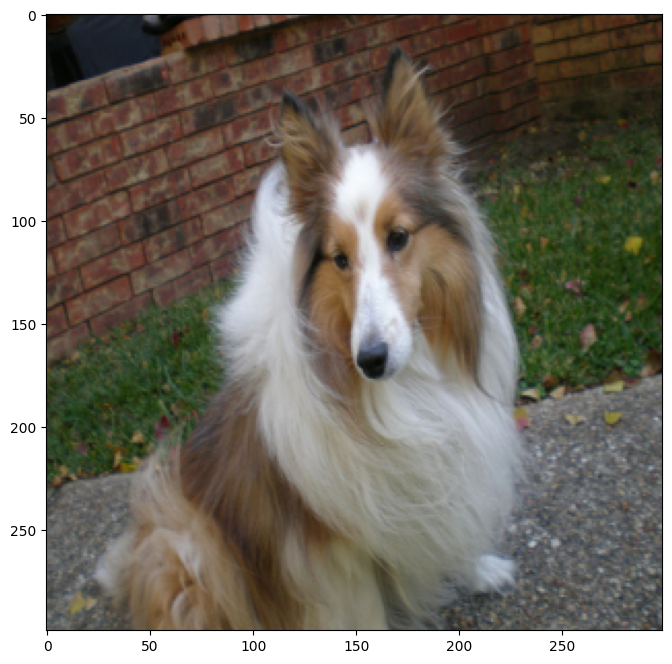

In [27]:
display_images(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


collie: 5.7107615
Shetland_sheepdog: 5.085281
borzoi: 2.4000976
turnstile: 2.0390768
Australian_terrier: 1.9292631
spotted_salamander: 1.7432896


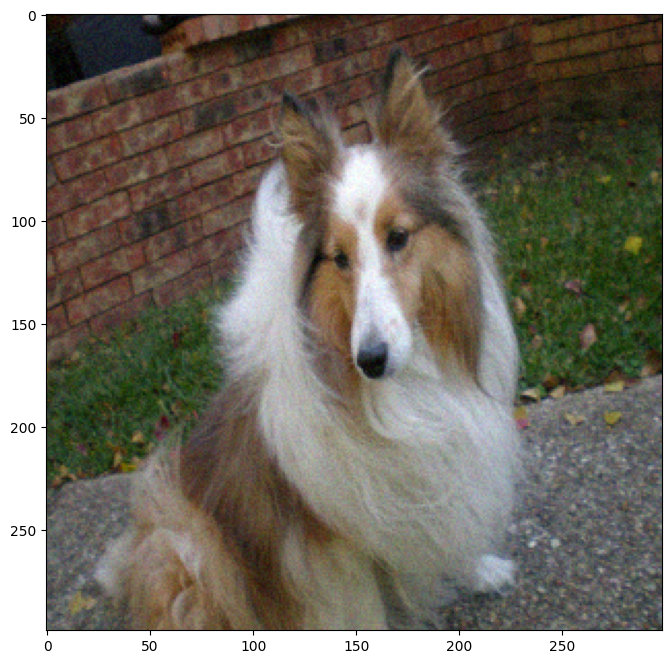

In [28]:
display_images(res.reshape(1, 299, 299, 3))

In [ ]:
def NESPO(
    x_orig,
    y_adv,
    y_correct,
    sigma,
    n_samples,
    k
):
    """
    x: np.ndarray
    y_class: str
    sigma: float
    n_samples: int
    img_dim: tuple
    classifier: function
    model: tf.keras.Model
    k: int
    """
    _, r, d, _ = x_orig.shape
    noise = torch.normal(mean = 0, std = 1, size = (n_samples//2, 3, r, d))
    noise = torch.cat([noise, -noise], axis = 0).cuda()
    x_orig = transforming(x_orig)
    x = x_orig.repeat((n_samples, 1, 1, 1)).cuda()
    x += noise * sigma
    predictions = pretrained_model(x)
    prob = torch.nn.functional.softmax(predictions).detach()[:, y_adv]
    prob = prob[:, None, None, None]
    g = prob * noise
    return g.sum(dim = 0).unsqueeze(0) / (n_samples)

In [57]:
cls_orig = classfiles[0]
# print(images[cls])
imgfile = random.choice(images[cls_orig])
# imgfile = images[cls]
imgpath = os.path.join(data_path, cls_orig+"/"+imgfile)
# imgpath = imgfile
# print(cls)
print(imgfile)
print(imgpath)

rawimage = Image.open(imgpath)
image = tf.keras.preprocessing.image.img_to_array(rawimage)
# 299, 299, 3
# print(np.shape(image))
# print(type(image))
# image = torchvision.transforms.functional.pil_to_tensor(rawimage)

image = tf.cast(image, tf.float32)
# print(type(image))

image = image/255
image = tf.image.resize(image, (imagesize, imagesize))
# print(type(image))
# Add batch dimension
# 1, 299, 299, 3
image = image[None, ...]

# image = preprocess(image)
# print(np.shape(image))

imgplot_orig = rawimage

img_orig = image

cls_adv = classfiles[1]
# print(images[cls])
imgfile = random.choice(images[cls_adv])
# imgfile = images[cls]
imgpath = os.path.join(data_path, cls_adv+"/"+imgfile)
# imgpath = imgfile
# print(cls)
print(imgfile)
print(imgpath)

rawimage = Image.open(imgpath)
image = tf.keras.preprocessing.image.img_to_array(rawimage)
# 299, 299, 3
# print(np.shape(image))
# print(type(image))
# image = torchvision.transforms.functional.pil_to_tensor(rawimage)

image = tf.cast(image, tf.float32)
# print(type(image))

image = image/255
image = tf.image.resize(image, (imagesize, imagesize))
# print(type(image))
# Add batch dimension
# 1, 299, 299, 3
image = image[None, ...]

# image = preprocess(image)
# print(np.shape(image))

imgplot_adv = rawimage

print(image.shape)
img_adv = image


ILSVRC2012_val_00000005.JPEG
/content/Adversarial-Black-Box-Attacker/NESattack/imagenet_val/n03125729/ILSVRC2012_val_00000005.JPEG
ILSVRC2012_val_00000001.JPEG
/content/Adversarial-Black-Box-Attacker/NESattack/imagenet_val/n01751748/ILSVRC2012_val_00000001.JPEG
(1, 299, 299, 3)


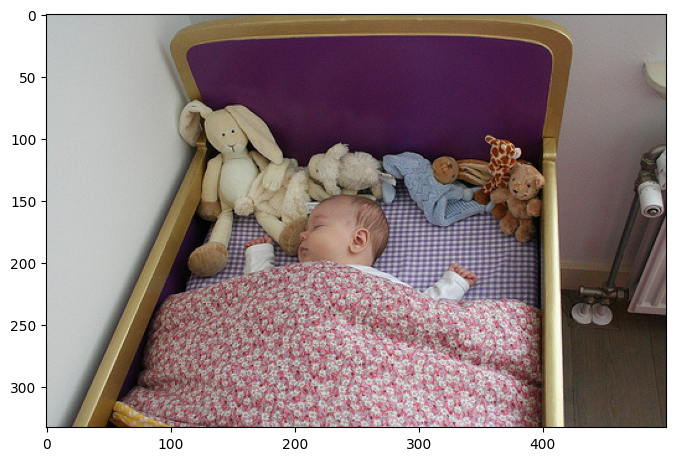

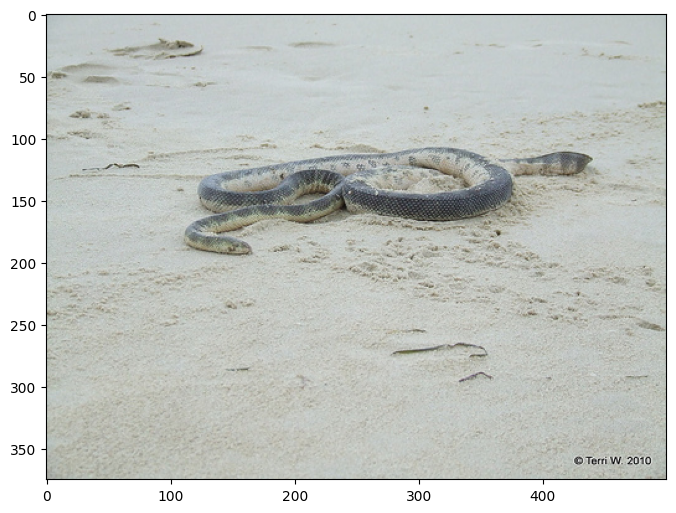

In [36]:
plt.imshow(imgplot_orig)
plt.show()
plt.imshow(imgplot_adv)

In [68]:
class PartialInfoAttack:
    def __init__(
        self,
        e_adv,
        e_0,
        sigma,
        n_samples,
        eps_decay,
        max_lr,
        min_lr,
        k,
        max_queries
    ):
        self.e_adv = e_adv
        self.e_0 = e_0
        self.sigma = sigma
        self.n_samples = n_samples
        self.eps_decay = eps_decay
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.k = k
        self.max_queries = max_queries

    def attack(
        self,
        x_adv,
        y_adv,
        x_orig
    ):
        """
        x_adv: np.ndarray
        y_adv: str
        classifier: function
        x_orig: np.ndarray
        """
        epsilon = self.e_0

        lower = np.clip(x_orig - epsilon, 0, 1)
        upper = np.clip(x_orig + epsilon, 0, 1)
        x_adv = np.clip(x_adv, lower, upper)

        count = 0
        while count < self.max_queries and (epsilon > self.e_adv or y_adv != torch.argmax(pretrained_model(transforming(x_adv).cuda())).detach().cpu().numpy().item()):
            # print(count, epsilon, torch.max(x_adv - x_orig))
            g = NES(
                x_adv,
                y_adv,
                0,
                self.sigma,
                self.n_samples,
                self.k
            )
            count += self.n_samples
            lr = self.max_lr
            g = torch.sign(g).cpu().detach().numpy().transpose(0, 2, 3, 1)
            hat_x_adv = x_adv + lr * g

            # print("hey: ", get_top_k_labels(self.model, hat_x_adv, 1)[0])
            probs = pretrained_model(transforming(hat_x_adv).cuda())
            topk = torch.topk(probs, self.k) # .detach().numpy()
            while y_adv not in topk:
                count += 1
                if count > self.max_queries:
                    return x_adv
                if lr < self.min_lr:
                    epsilon += self.eps_decay
                    self.eps_decay /= 2
                    hat_x_adv = x_adv
                    break

                proposed_eps = max(epsilon - self.eps_decay, self.e_adv)
                print(proposed_eps)
                lower = np.clip(x_orig - proposed_eps, 0, 1)
                upper = np.clip(x_orig + proposed_eps, 0, 1)
                lr /= 2
                hat_x_adv = np.clip(x_adv + lr * g, lower, upper)
            proposed_eps = max(epsilon - self.eps_decay, self.e_adv)

            lower = np.clip(x_orig - proposed_eps, 0, 1)
            upper = np.clip(x_orig + proposed_eps, 0, 1)
            hat_x_adv = np.clip(hat_x_adv, lower, upper)
            x_adv = hat_x_adv
            epsilon -= self.eps_decay

            probs = torch.nn.functional.softmax(pretrained_model(transforming(x_adv).cuda())).cpu().detach().numpy()
            print(decode_predictions(probs, top = 1), epsilon)

        return x_adv

sigma = 0.001
eps_decay = 0.001
e_0 = 0.5
n_samples = 50
k = 1
e_adv = 0.05
max_queries = 20000
max_lr = 0.01
min_lr = 0.001



attacker = PartialInfoAttack(
    e_adv,
    e_0,
    sigma,
    n_samples,
    eps_decay,
    max_lr,
    min_lr,
    k,
    max_queries
)

In [70]:
y_adv = 65

res = attacker.attack(img_adv, y_adv, img_orig)

<ipython-input-18-f8056fdcb327>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(predictions).detach()[:, y_adv]
<ipython-input-68-19ba42621814>:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(pretrained_model(transforming(x_adv).cuda())).cpu().detach().numpy()


[[('n01751748', 'sea_snake', 0.6313688)]] 0.499
[[('n01751748', 'sea_snake', 0.75599927)]] 0.498
[[('n01751748', 'sea_snake', 0.8358459)]] 0.497
[[('n01751748', 'sea_snake', 0.8883009)]] 0.496
[[('n01751748', 'sea_snake', 0.8894625)]] 0.495
[[('n01751748', 'sea_snake', 0.9352871)]] 0.494
[[('n01751748', 'sea_snake', 0.93050206)]] 0.493
[[('n01751748', 'sea_snake', 0.9482452)]] 0.492
[[('n01751748', 'sea_snake', 0.96492785)]] 0.491
[[('n01751748', 'sea_snake', 0.9683027)]] 0.49
[[('n01751748', 'sea_snake', 0.97676075)]] 0.489
[[('n01751748', 'sea_snake', 0.9747746)]] 0.488
[[('n01751748', 'sea_snake', 0.96718866)]] 0.487
[[('n01751748', 'sea_snake', 0.9809161)]] 0.486
[[('n01751748', 'sea_snake', 0.99053663)]] 0.485
[[('n01751748', 'sea_snake', 0.99047965)]] 0.484
[[('n01751748', 'sea_snake', 0.9931636)]] 0.483
[[('n01751748', 'sea_snake', 0.9913406)]] 0.482
[[('n01751748', 'sea_snake', 0.99466264)]] 0.481
[[('n01751748', 'sea_snake', 0.99569726)]] 0.48
[[('n01751748', 'sea_snake', 0.99

In [73]:
res.shape

(1, 299, 299, 3)

sea_snake: 15.929999
hair_spray: 7.111256
king_snake: 6.440895
diamondback: 6.1502504
armadillo: 6.0348487
Gila_monster: 5.4233212


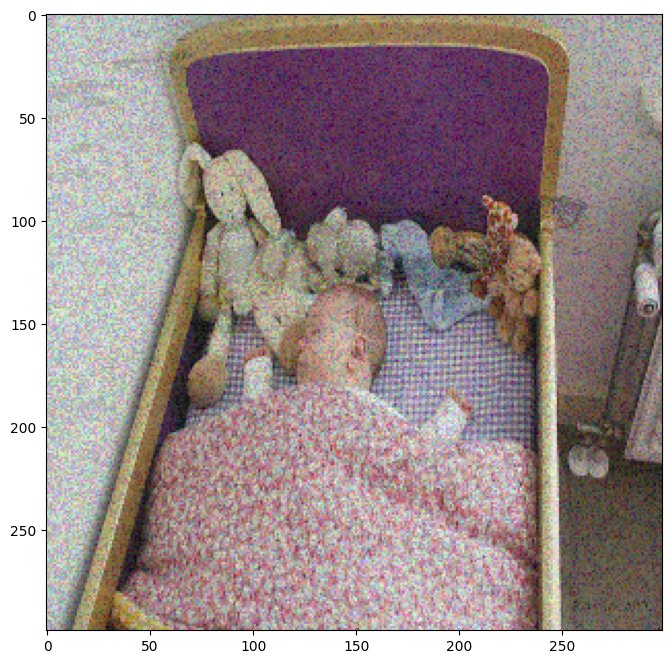

In [77]:
display_images(res)